## Car Park

The city's street parking system, which charges a fixed rate, is struggling to keep up with the increased demand. => modify the pricing scheme to better promote social welfare. 
- one spot is left unoccupied (so that it is available in case someone really needs it).
- Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import time
import json
from copy import deepcopy
class CarPark:
    def __init__(self,
                 num_spaces=10,
                 num_prices=4,
                 price_factor=0.1,
                 occupants_factor=1.0,
                 null_factor=1 / 3):
        self.__num_spaces = num_spaces
        self.__num_prices = num_prices
        self.__occupants_factor = occupants_factor
        self.__price_factor = price_factor
        self.__null_factor = null_factor
        self.__S = [num_occupied for num_occupied in range(num_spaces + 1)]
        self.__A = list(range(num_prices))


    def transitions(self, s, a):
        return np.array([[r, self.p(s_, r, s, a)] for s_, r in self.support(s, a)])

    def support(self, s, a):
        return [(s_, self.reward(s, s_)) for s_ in self.__S]

    def p(self, s_, r, s, a):
        if r != self.reward(s, s_):
            return 0
        else:
            center = (1 - self.__price_factor
                      ) * s + self.__price_factor * self.__num_spaces * (
                          1 - a / self.__num_prices)
            emphasis = np.exp(
                -abs(np.arange(2 * self.__num_spaces) - center) / 5)
            if s_ == self.__num_spaces:
                return sum(emphasis[s_:]) / sum(emphasis)
            return emphasis[s_] / sum(emphasis)

    def reward(self, s, s_):
        return self.state_reward(s) + self.state_reward(s_)

    def state_reward(self, s):
        if s == self.__num_spaces:
            return self.__null_factor * s * self.__occupants_factor
        else:
            return s * self.__occupants_factor

    def random_state(self):
        return np.random.randint(self.__num_prices)

    def step(self, s, a):
        probabilities = [
            self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S
        ]
        return np.random.choice(self.__S, p=probabilities)

    @property
    def A(self):
        return list(self.__A)

    @property
    def num_spaces(self):
        return self.__num_spaces

    @property
    def num_prices(self):
        return self.num_prices

    @property
    def S(self):
        return list(self.__S)


class Transitions(list):
    def __init__(self, transitions):
        self.__transitions = transitions
        super().__init__(transitions)

    def __repr__(self):
        repr = '{:<14} {:<10} {:<10}'.format('Next State', 'Reward',
                                             'Probability')
        repr += '\n'
        for i, (s, r, p) in enumerate(self.__transitions):
            repr += '{:<14} {:<10} {:<10}'.format(s, round(r, 2), round(p, 2))
            if i != len(self.__transitions) - 1:
                repr += '\n'
        return repr

In [0]:
%%capture
%matplotlib inline
import numpy as np
import pickle

In [0]:
num_spaces = 3
num_prices = 3
env = CarPark(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

The value function is a one-dimensional array where the $i$-th entry gives the value of $i$ spaces being occupied.

In [5]:
V

array([0., 0., 0., 0.])

In [0]:
state = 0
V[state]

0.0

In [0]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [0]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


## Policy Evaluation

First, Evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$  
 
 

In [0]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [0]:
def bellman_update(env, V, pi, s, gamma):
    v = 0
    for a in env.A:
        for s_, (r, p) in enumerate(env.transitions(s, a)):
            v += pi[s][a] * p * (r + gamma * V[s_])
    V[s] = v

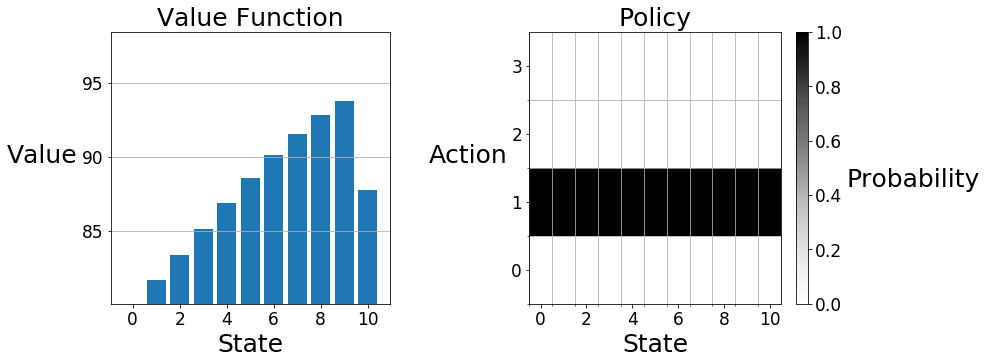

In [0]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
num_spaces = 10
num_prices = 4
env = CarPark(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)
tools.plot(V, city_policy)

The output (rounded to one decimal place) against the answer below:<br>
State $\quad\quad$    Value<br>
0 $\quad\quad\quad\;$        80.0<br>
1 $\quad\quad\quad\;$        81.7<br>
2 $\quad\quad\quad\;$        83.4<br>
3 $\quad\quad\quad\;$        85.1<br>
4 $\quad\quad\quad\;$        86.9<br>
5 $\quad\quad\quad\;$        88.6<br>
6 $\quad\quad\quad\;$        90.1<br>
7 $\quad\quad\quad\;$        91.6<br>
8 $\quad\quad\quad\;$        92.8<br>
9 $\quad\quad\quad\;$        93.8<br>
10 $\quad\quad\;\;\,\,$       87.8<br>

## Policy Iteration
Compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. 

In [0]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [0]:
def q_greedify_policy(env, V, pi, s, gamma):
    v_opt = float('-inf')
    a_opt = 0
    for a in env.A:
        transitions = env.transitions(s,a)
        v_s = 0
        for s_ in env.S:
            v_s += transitions[s_][1] * ( transitions[s_][0] + gamma * V[s_] )
        if v_s > v_opt:
            v_opt = v_s
            a_opt = a
    pi[s] = np.zeros_like(pi[s])
    pi[s][a_opt] = 1

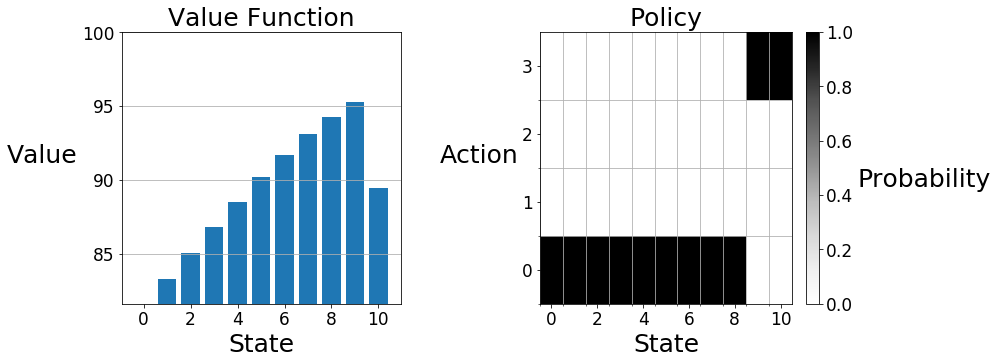

In [0]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = CarPark(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)
tools.plot(V, pi)

The value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

## Value Iteration
Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$

In [0]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [0]:
def bellman_optimality_update(env, V, s, gamma):
    V_s_opt = - float('inf')
    for a in env.A:
        transitions = env.transitions(s, a)
        v_s = 0
        for s_, (r, p) in enumerate(transitions):
            v_s += p * (r + gamma * V[s_])
        if V_s_opt < v_s:
            V_s_opt = v_s
    V[s] = V_s_opt

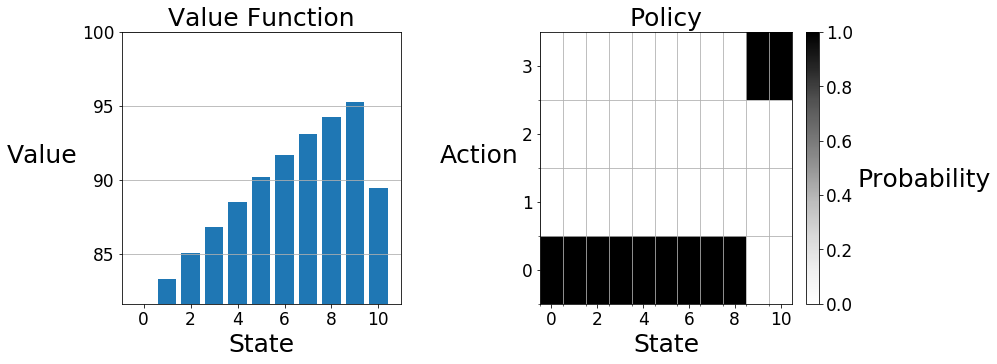

In [0]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = CarPark(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)
tools.plot(V, pi)

The value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

In [0]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

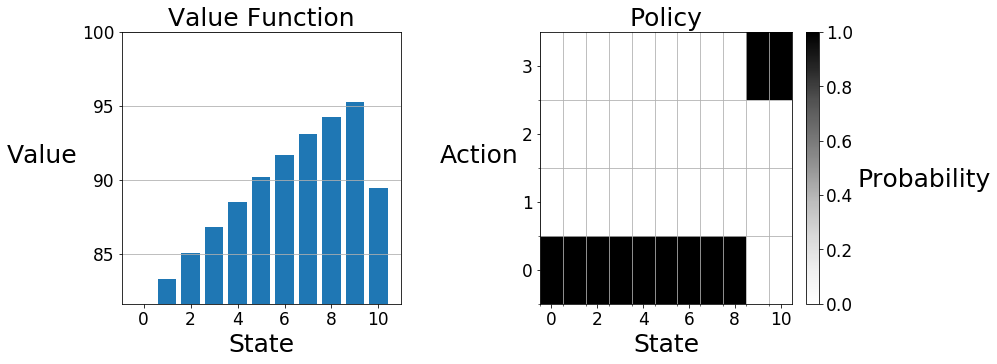

In [0]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = CarPark(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)